In [1]:
pip install meteostat

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install fuzzywuzzy[speedup] pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import requests
import json
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily
import pandas as pd
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time
import folium
from folium import Marker
from folium.plugins import HeatMap
from fuzzywuzzy import process
import numpy as np

In [4]:
uni_data = pd.DataFrame(columns=['University Name','In State Tuition','Out of State Tuition','Admission Rate','Number of Students','Graduation Rate 4-years',
                                'Earnings After 10 Years','Retention Rate','Diversity Score','Public or Private'])

university_list = ['Princeton University','Massachusetts Institute of Technology','Harvard University','Stanford University','Yale University',
                   'California Institute of Technology','Duke University','Johns Hopkins University','Northwestern University',
                   'University of Pennsylvania','Cornell University','University of Chicago','Brown University','Columbia University',
                   'Dartmouth College','University of California-Los Angeles','University of California-Berkeley','Rice University','University of Notre Dame','Vanderbilt University', 'Carnegie Mellon University',
                  'University of Michigan','Washington University','Emory University',"Georgetown University","University of Virginia",
                   "University of North Carolina-Chapel Hill", "University of Southern California","University of California-San Diego",
                   "New York University","University of Florida","University of Texas-Austin","Georgia Institute of Technology",
                   "University of California-Davis","University of California-Irvine","University of Illinois-Urbana-Champaign","Boston College",
                   "Tufts University","University of California-Santa Barbara","University of Wisconsin-Madison","Boston University",
                   "Ohio State University","Rutgers University","University of Maryland","University of Rochester",
                   "Lehigh University","Purdue University","University of Georgia","University of Washington","Wake Forest University"]

for university in university_list:
    url = "https://api.data.gov/ed/collegescorecard/v1/schools?api_key=OvEQIo28yxxsUWagGnOrXt9vuxU1WbanzSm1V8Dp&school.name="+university+"&fields=id,school.name,latest.cost.tuition.in_state,latest.cost.tuition.out_of_state,latest.admissions.admission_rate.overall,latest.student.size,latest.completion.rate_suppressed.four_year,latest.earnings.10_yrs_after_entry.median,latest.student.retention_rate.overall.full_time,latest.school.peps_ownership,latest.student.demographics.race_ethnicity.asian,latest.student.demographics.race_ethnicity.black,latest.student.demographics.race_ethnicity.white"
    response = requests.get(url)
    data = response.json()
    
    in_state_tuition = data['results'][0]['latest.cost.tuition.in_state']
    out_of_state_tuition = data['results'][0]['latest.cost.tuition.out_of_state']
    admission_rate = data['results'][0]['latest.admissions.admission_rate.overall']
    student_size = data['results'][0]['latest.student.size']
    completion_rate = data['results'][0]['latest.completion.rate_suppressed.four_year']
    earning_10year = data['results'][0]['latest.earnings.10_yrs_after_entry.median']
    retention_rate = data['results'][0]['latest.student.retention_rate.overall.full_time']
    ownership = data['results'][0]['latest.school.peps_ownership']
    prop_white = data['results'][0]['latest.student.demographics.race_ethnicity.white']
    prop_black = data['results'][0]['latest.student.demographics.race_ethnicity.black']
    prop_asian = data['results'][0]['latest.student.demographics.race_ethnicity.asian']

    if all(p is not None for p in [prop_white, prop_black, prop_asian]):
        prop_other = 1-prop_white-prop_black-prop_asian
        proportions = [prop_white,prop_black,prop_asian,prop_other]
        diversity_score = 1 - sum(p**2 for p in proportions)
    else:
        diversity_score = None
        
    uni_data.loc[len(uni_data)] = {'University Name': university, 'In State Tuition': in_state_tuition, 'Out of State Tuition': out_of_state_tuition, 
                                   'Admission Rate': admission_rate, 'Number of Students': student_size,'Graduation Rate 4-years': completion_rate,
                                  'Earnings After 10 Years': earning_10year,'Retention Rate': retention_rate, 'Diversity Score': diversity_score,
                                   'Public or Private': ownership}

In [5]:
# Inputting missing data for cornell university
uni_data.loc[10, 'Admission Rate'] = 0.079
uni_data.loc[10, 'Number of Students'] = 16071
uni_data.loc[10, 'In State Tuition'] = 63200
uni_data.loc[10, 'Out of State Tuition'] = 63200
uni_data.loc[10, 'Retention Rate'] = 0.96
1-0.385-0.077-0.363
proportions = [0.303,0.0588,0.179,1-0.303-0.0588-0.179]
diversity_score = 1 - sum(p**2 for p in proportions)
uni_data.loc[10, 'Diversity Score'] = diversity_score
# Inputting missing data for California Institute of Technology
uni_data.loc[5, 'Admission Rate'] = 0.027
# Inputting missing data for Boston College
uni_data.loc[36, 'Admission Rate'] = 0.167
# Inputting missing data for Ohio State University
uni_data.loc[41, 'Admission Rate'] = 0.027

In [6]:
uni_data.head(50)

,University Name,In State Tuition,Out of State Tuition,Admission Rate,Number of Students,Graduation Rate 4-years,Earnings After 10 Years,Retention Rate,Diversity Score,Public or Private
0,Princeton University,57410,57410,0.0570,5527,0.9744,110066,0.9705,0.701479,Private Nonprofit
1,Massachusetts Institute of Technology,57986,57986,0.0396,4638,0.9557,143372,0.9898,0.699191,Private Nonprofit
2,Harvard University,57261,57261,0.0324,7973,0.9726,101817,0.9769,0.703174,Private Nonprofit
3,Stanford University,58416,58416,0.0368,7761,0.9534,124080,0.9831,0.694972,Private Nonprofit
4,Yale University,62250,62250,0.0457,6639,0.9736,100533,0.9810,0.702715,Private Nonprofit
5,California Institute of Technology,19190,19190,0.0270,540,0.7828,53598,0.9474,0.483280,Proprietary
6,Duke University,62688,62688,0.0635,6570,0.9625,97800,0.9685,0.700444,Private Nonprofit
7,Johns Hopkins University,60480,60480,0.0725,5643,0.9433,87555,0.9695,0.688898,Private Nonprofit
8,Northwestern University,8672,19460,0.9793,6243,0.4528,47021,0.6115,0.600800,Public
9,University of Pennsylvania,63452,63452,0.0650,10572,0.9615,111371,0.9837,0.709739,Private Nonprofit


In [7]:
standard_names = ['Princeton University',
 'Massachusetts Institute of Technology',
 'Harvard University',
 'Stanford University',
 'Yale University',
 'California Institute of Technology',
 'Duke University',
 'Johns Hopkins University',
 'Northwestern University',
 'University of Pennsylvania',
 'Cornell University',
 'University of Chicago',
 'Brown University',
 'Columbia University',
 'Dartmouth College',
 'University of California, Los Angeles',
 'University of California, Berkeley',
 'Rice University',
 'University of Notre Dame',
 'Vanderbilt University',
 'Carnegie Mellon University',
 'University of Michigan, Ann Arbor',
 'Washington University in St. Louis',
 'Emory University',
 'Georgetown University',
 'University of Virginia',
 'University of North Carolina, Chapel Hill',
 'University of Southern California',
 'University of California, San Diego',
 'New York University',
 'University of Florida',
 'University of Texas, Austin',
 'Georgia Institute of Technology',
 'University of California, Davis',
 'University of California, Irvine',
 'University of Illinois, Urbana-Champaign',
 'Boston College',
 'Tufts University',
 'University of California, Santa Barbara',
 'University of Wisconsin, Madison',
 'Boston University',
 'Ohio State University, Columbus',
 'Rutgers University, New Brunswick',
 'University of Maryland, College Park',
 'University of Rochester',
 'Lehigh University',
 'Purdue University',
 'University of Georgia',
 'University of Washington',
 'Wake Forest University']

In [8]:
def standardize_column_values(df, column, standard_names, threshold=80):

    updated_values = []
    
    for value in df[column]:
        match, score = process.extractOne(value, standard_names)
        if score >= threshold:
            updated_values.append(match)  # Use the matched standard name
        else:
            updated_values.append(value)  # Keep the original name if no good match
    
    df[column] = updated_values
    return df

In [9]:
uni_data = standardize_column_values(uni_data, 'University Name', standard_names, threshold=80)
uni_data.head(50)

,University Name,In State Tuition,Out of State Tuition,Admission Rate,Number of Students,Graduation Rate 4-years,Earnings After 10 Years,Retention Rate,Diversity Score,Public or Private
0,Princeton University,57410,57410,0.0570,5527,0.9744,110066,0.9705,0.701479,Private Nonprofit
1,Massachusetts Institute of Technology,57986,57986,0.0396,4638,0.9557,143372,0.9898,0.699191,Private Nonprofit
2,Harvard University,57261,57261,0.0324,7973,0.9726,101817,0.9769,0.703174,Private Nonprofit
3,Stanford University,58416,58416,0.0368,7761,0.9534,124080,0.9831,0.694972,Private Nonprofit
4,Yale University,62250,62250,0.0457,6639,0.9736,100533,0.9810,0.702715,Private Nonprofit
5,California Institute of Technology,19190,19190,0.0270,540,0.7828,53598,0.9474,0.483280,Proprietary
6,Duke University,62688,62688,0.0635,6570,0.9625,97800,0.9685,0.700444,Private Nonprofit
7,Johns Hopkins University,60480,60480,0.0725,5643,0.9433,87555,0.9695,0.688898,Private Nonprofit
8,Northwestern University,8672,19460,0.9793,6243,0.4528,47021,0.6115,0.600800,Public
9,University of Pennsylvania,63452,63452,0.0650,10572,0.9615,111371,0.9837,0.709739,Private Nonprofit


In [10]:
# Building a function to find the coordinates of a given location (latitude & longitude)

In [11]:
def find_coordinates(location_name):
    """
    Finds the latitude and longitude of the location (str)
    """
    geolocator = Nominatim(user_agent="geo_locator")
    try:
        location = geolocator.geocode(location_name)
        return location.latitude, location.longitude
    except GeocoderTimedOut:
        time.sleep(1)  
        return find_coordinates(location_name)

In [12]:
# Apply the function to find coordinates and add new columns
uni_data[['Latitude', 'Longitude']] = uni_data['University Name'].apply(lambda name: pd.Series(find_coordinates(name)))

In [13]:
uni_data.head(50)

,University Name,In State Tuition,Out of State Tuition,Admission Rate,Number of Students,Graduation Rate 4-years,Earnings After 10 Years,Retention Rate,Diversity Score,Public or Private,Latitude,Longitude
0,Princeton University,57410,57410,0.0570,5527,0.9744,110066,0.9705,0.701479,Private Nonprofit,40.338675,-74.658365
1,Massachusetts Institute of Technology,57986,57986,0.0396,4638,0.9557,143372,0.9898,0.699191,Private Nonprofit,42.358253,-71.096627
2,Harvard University,57261,57261,0.0324,7973,0.9726,101817,0.9769,0.703174,Private Nonprofit,42.365743,-71.122214
3,Stanford University,58416,58416,0.0368,7761,0.9534,124080,0.9831,0.694972,Private Nonprofit,37.431314,-122.169365
4,Yale University,62250,62250,0.0457,6639,0.9736,100533,0.9810,0.702715,Private Nonprofit,41.257131,-72.989670
5,California Institute of Technology,19190,19190,0.0270,540,0.7828,53598,0.9474,0.483280,Proprietary,34.137014,-118.125288
6,Duke University,62688,62688,0.0635,6570,0.9625,97800,0.9685,0.700444,Private Nonprofit,36.000156,-78.944230
7,Johns Hopkins University,60480,60480,0.0725,5643,0.9433,87555,0.9695,0.688898,Private Nonprofit,39.330202,-76.621854
8,Northwestern University,8672,19460,0.9793,6243,0.4528,47021,0.6115,0.600800,Public,42.055716,-87.675295
9,University of Pennsylvania,63452,63452,0.0650,10572,0.9615,111371,0.9837,0.709739,Private Nonprofit,39.949340,-75.189649


In [14]:
# Create a map centered on North America
map_na = folium.Map(location=[39.8283, -98.5795], tiles='cartodbpositron', zoom_start=4)

# Add universities to the map based on location
for idx, row in uni_data.iterrows():
    folium.Marker(location=[row["Latitude"], row["Longitude"]],popup=f"{row['University Name']}").add_to(map_na)

# Display map
map_na

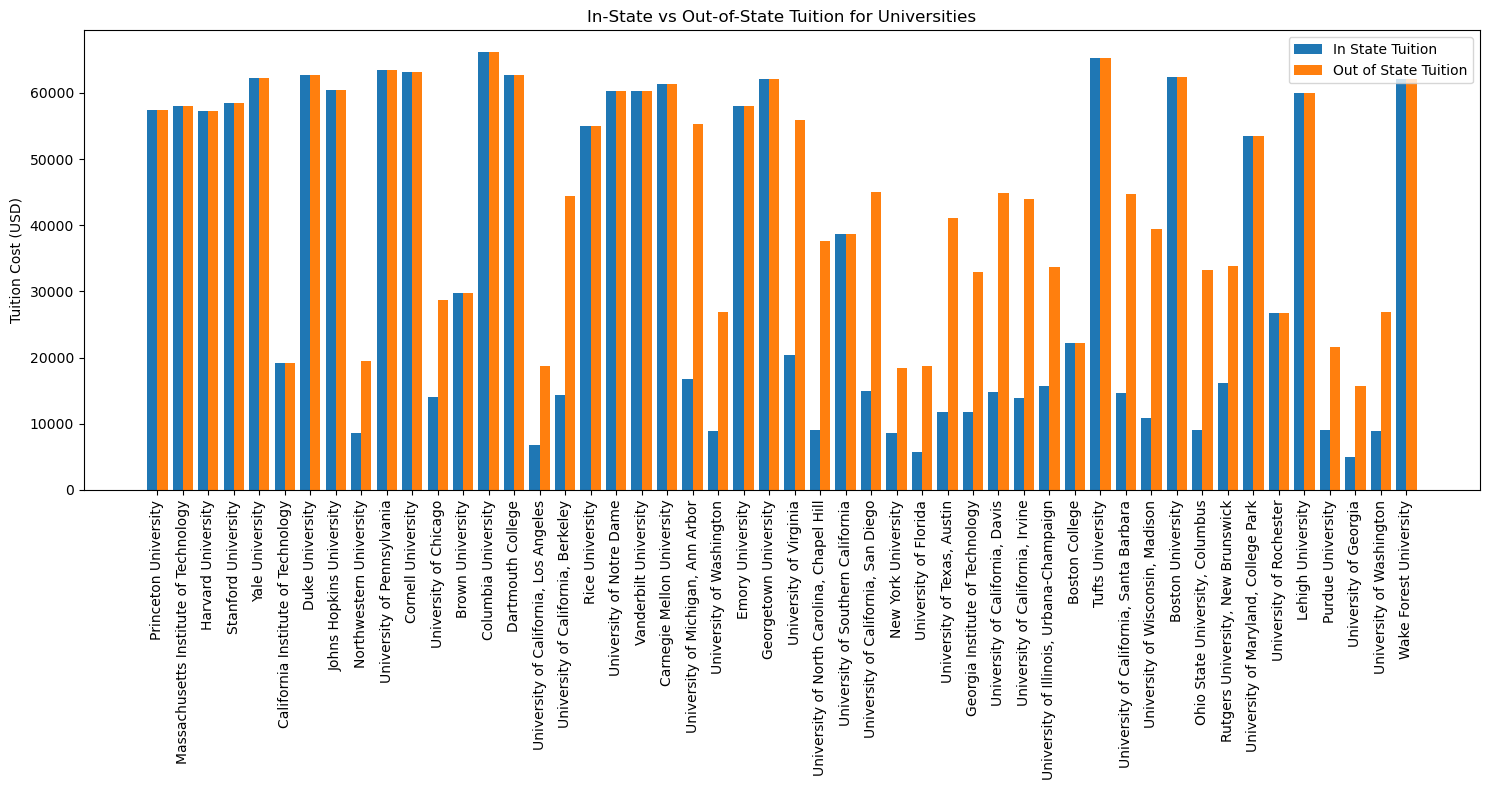

In [15]:
# Plot double bar graph
x = range(len(uni_data))
plt.figure(figsize=(15, 8))
plt.bar(x, uni_data["In State Tuition"], width=0.4, label='In State Tuition', align='center')
plt.bar([i + 0.4 for i in x], uni_data["Out of State Tuition"], width=0.4, label='Out of State Tuition', align='center')
plt.xticks([i + 0.2 for i in x], uni_data["University Name"], rotation=90)
plt.ylabel("Tuition Cost (USD)")
plt.title("In-State vs Out-of-State Tuition for Universities")
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# Define a function to create a heatmap
def create_heatmap(dataframe, column):
    
    # Initialize a map of North America
    heatmap = folium.Map(location=[39.8283, -98.5795], tiles='cartodbpositron', zoom_start=4)
    
    # Viridis color scale
    viridis_gradient = {
        0.0: '#440154',  # Dark purple
        0.2: '#3b528b',  # Blue
        0.4: '#21908d',  # Teal
        0.6: '#5ec962',  # Green
        0.8: '#fde725',  # Yellow
        1.0: '#ffffbf'   # Light yellow
    }
    
    # Extract Data & Create Layer
    heatmap_data = list(zip(dataframe["Latitude"], dataframe["Longitude"], dataframe[column]))
    HeatMap(data=heatmap_data, radius=20, gradient=viridis_gradient).add_to(heatmap)
    
    return heatmap

In [17]:
# Create heatmaps for in-state and out-of-state tuition
heatmap_in_state = create_heatmap(uni_data, "In State Tuition")
heatmap_out_of_state = create_heatmap(uni_data, "Out of State Tuition")

In [18]:
# Display heatmaps for in-state tuition 
heatmap_in_state 

In [19]:
# Display heatmaps for out of state tuition 
heatmap_out_of_state

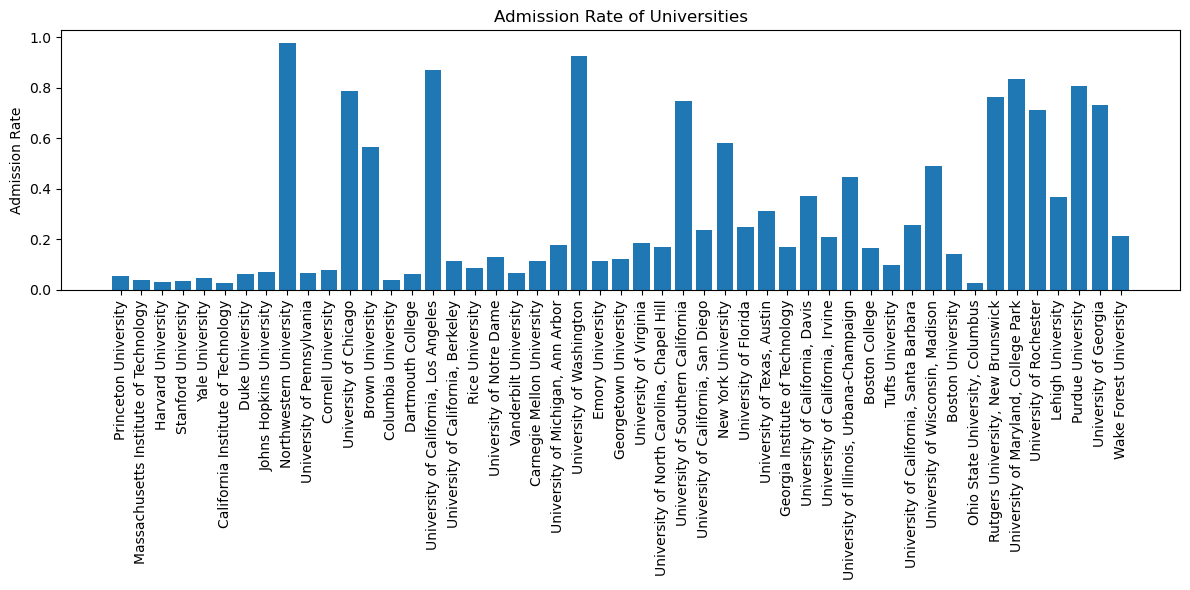

In [20]:
# Create bar graph for Admission Rate
plt.figure(figsize=(12, 6))
plt.bar(uni_data["University Name"], uni_data["Admission Rate"], align='center')
plt.xticks(rotation=90)
plt.ylabel("Admission Rate")
plt.title("Admission Rate of Universities")
plt.tight_layout()
plt.show()

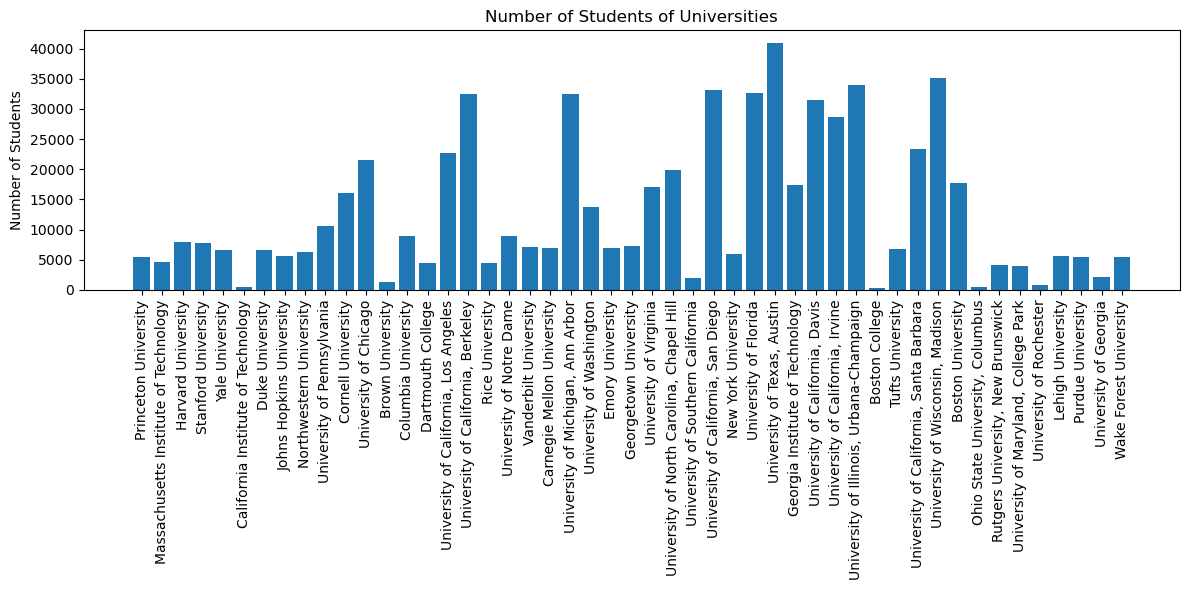

In [21]:
# Create bar graph for Number of Students
plt.figure(figsize=(12, 6))
plt.bar(uni_data["University Name"], uni_data["Number of Students"], align='center')
plt.xticks(rotation=90)
plt.ylabel("Number of Students")
plt.title("Number of Students of Universities")
plt.tight_layout()
plt.show()

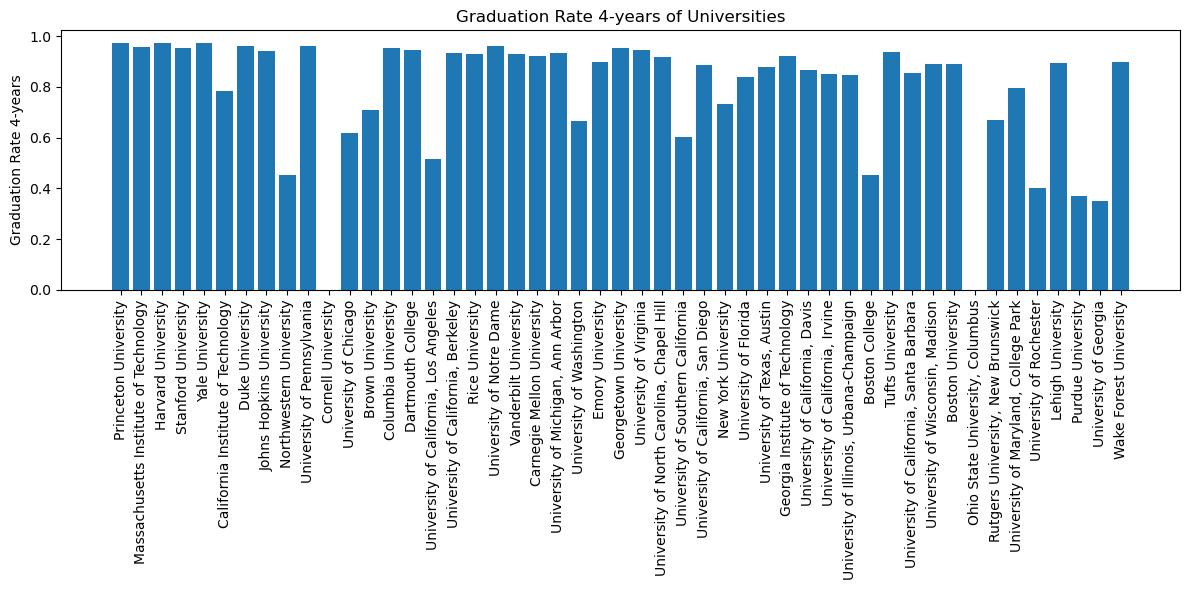

In [22]:
# Create bar graph for Graduation Rate 4-years
plt.figure(figsize=(12, 6))
plt.bar(uni_data["University Name"], uni_data["Graduation Rate 4-years"], align='center')
plt.xticks(rotation=90)
plt.ylabel("Graduation Rate 4-years")
plt.title("Graduation Rate 4-years of Universities")
plt.tight_layout()
plt.show()

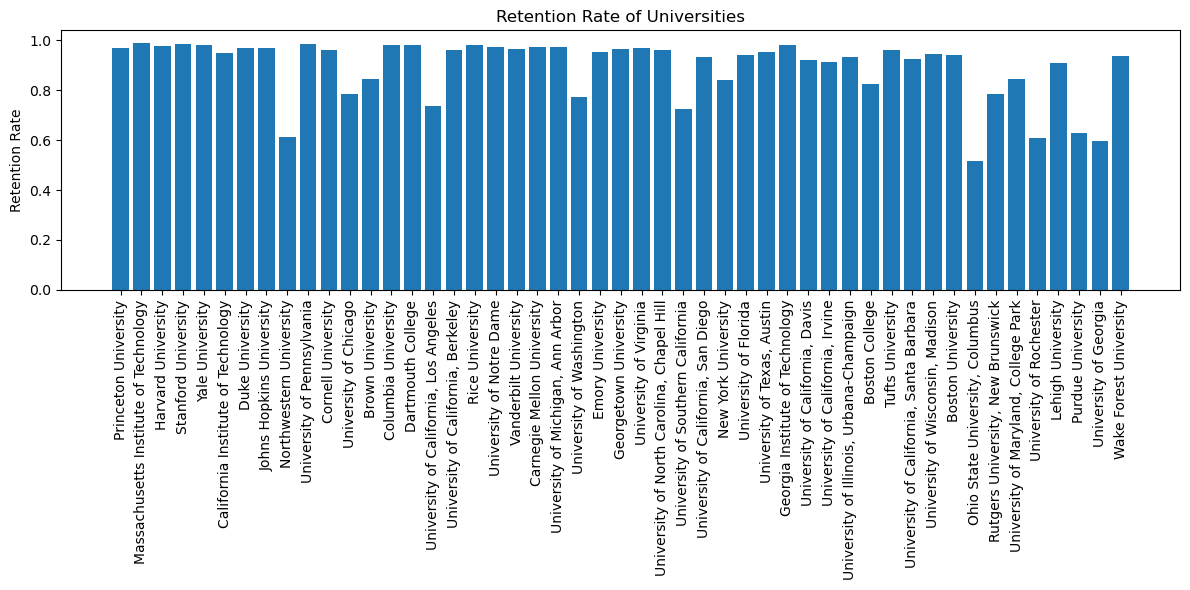

In [23]:
# Create bar graph for Retention Rate
plt.figure(figsize=(12, 6))
plt.bar(uni_data["University Name"], uni_data["Retention Rate"], align='center')
plt.xticks(rotation=90)
plt.ylabel("Retention Rate")
plt.title("Retention Rate of Universities")
plt.tight_layout()
plt.show()

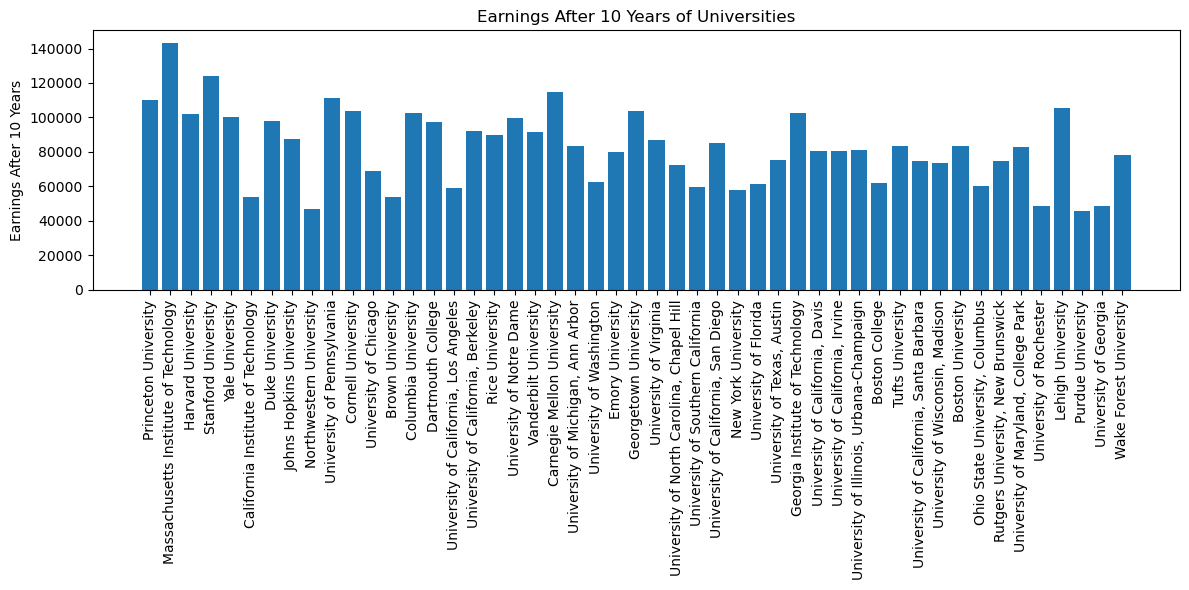

In [24]:
# Create bar graph for Earnings After 10 Years
plt.figure(figsize=(12, 6))
plt.bar(uni_data["University Name"], uni_data["Earnings After 10 Years"], align='center')
plt.xticks(rotation=90)
plt.ylabel("Earnings After 10 Years")
plt.title("Earnings After 10 Years of Universities")
plt.tight_layout()
plt.show()

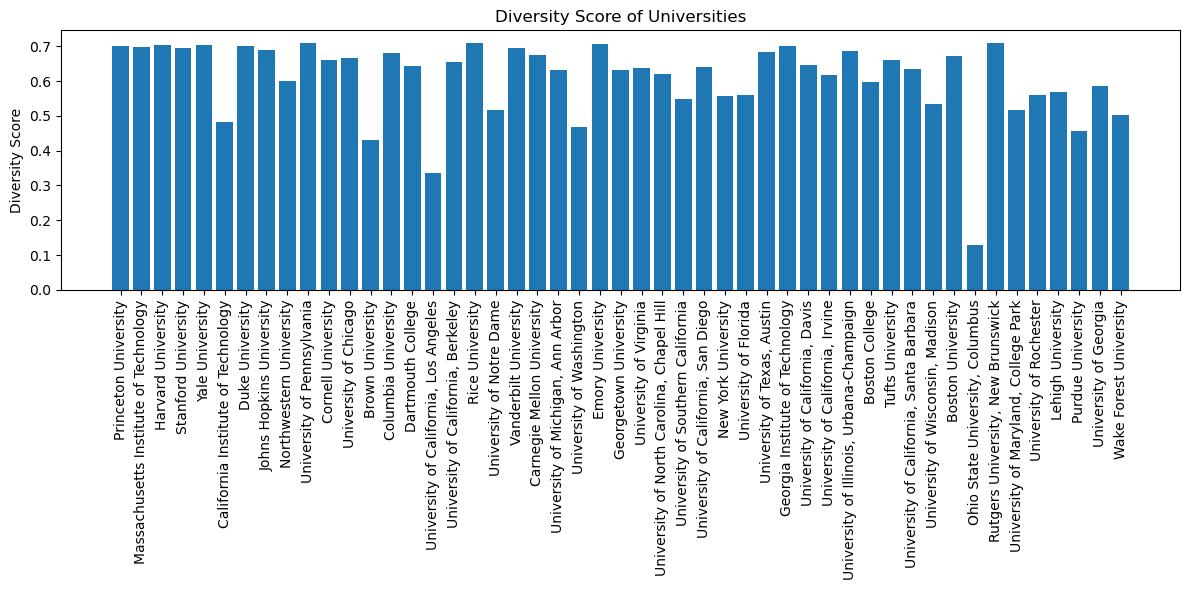

In [25]:
# Create bar graph for Diversity Score
plt.figure(figsize=(12, 6))
plt.bar(uni_data["University Name"], uni_data["Diversity Score"], align='center')
plt.xticks(rotation=90)
plt.ylabel("Diversity Score")
plt.title("Diversity Score of Universities")
plt.tight_layout()
plt.show()

In [26]:
# Further Analysis

In [27]:
# Separate data into Private and Public universities
private_uni_data = uni_data[uni_data["Public or Private"] == "Private Nonprofit"]
public_uni_data = uni_data[uni_data["Public or Private"] == "Public"]

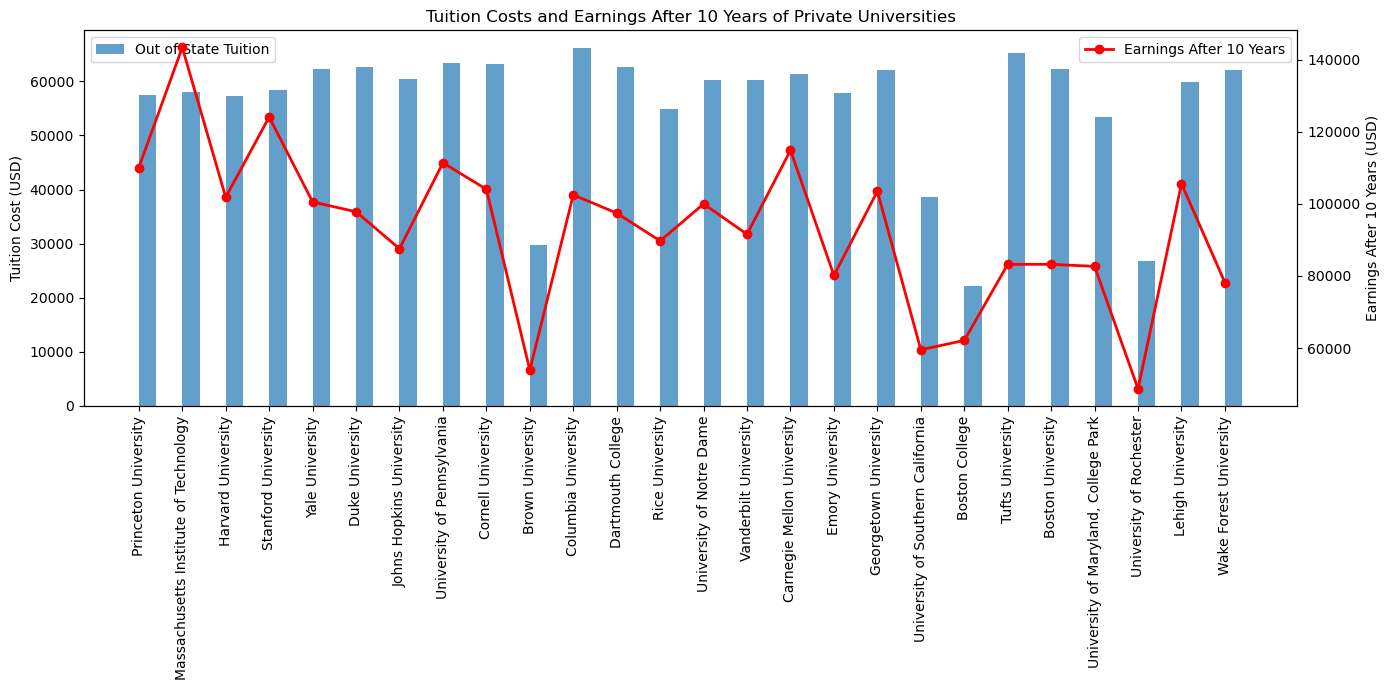

In [28]:
# Create a dual-axis plot for Private universities with Earnings After 10 Years & Tuition Cost
fig, ax1 = plt.subplots(figsize=(14, 7))
x = range(len(private_uni_data))
ax1.bar([i + 0.4 for i in x], private_uni_data["Out of State Tuition"], width=0.4, label='Out of State Tuition', align='center', alpha=0.7)
ax1.set_ylabel("Tuition Cost (USD)")
ax1.set_xticks([i + 0.2 for i in x])
ax1.set_xticklabels(private_uni_data["University Name"], rotation=90)
ax1.set_title("Tuition Costs and Earnings After 10 Years of Private Universities")
ax1.legend(loc="upper left")
ax2 = ax1.twinx()
ax2.plot([i + 0.2 for i in x], private_uni_data["Earnings After 10 Years"], color='red', marker='o', label='Earnings After 10 Years', linewidth=2)
ax2.set_ylabel("Earnings After 10 Years (USD)")
ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()

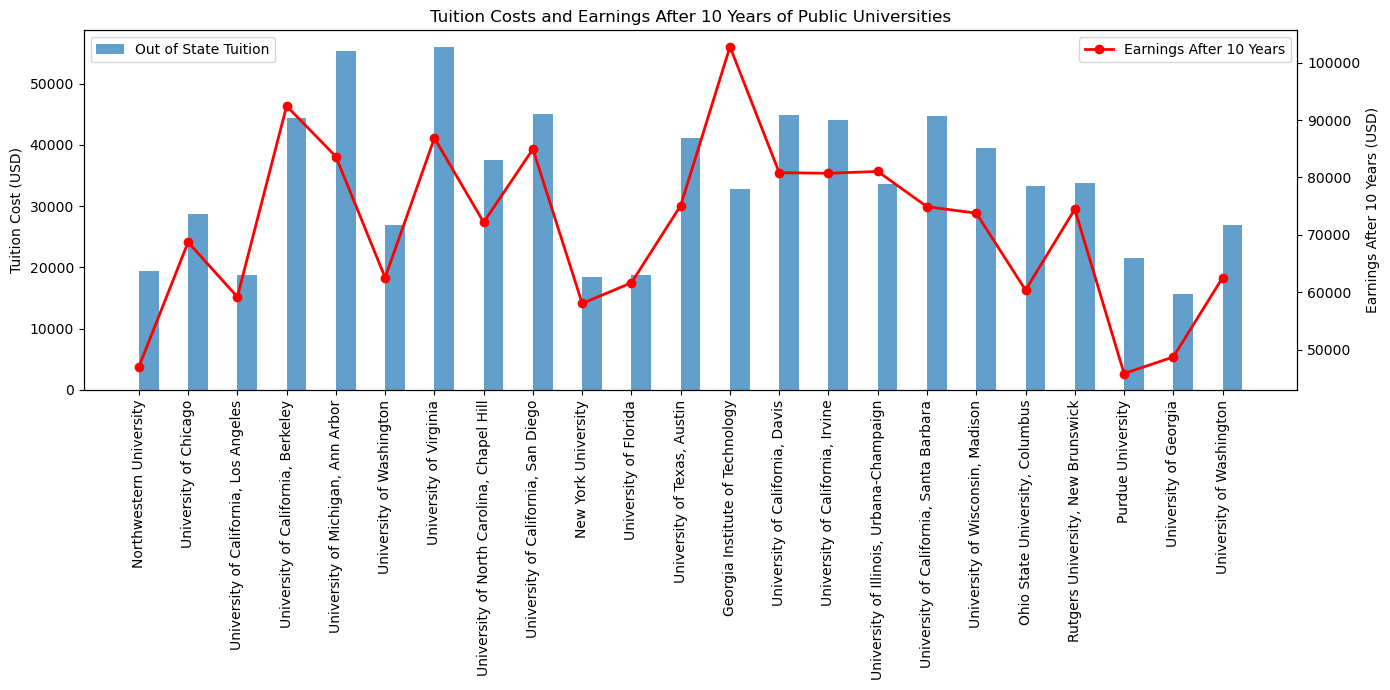

In [29]:
# Create a dual-axis plot for Public universities with Earnings After 10 Years & Tuition Cost
fig, ax1 = plt.subplots(figsize=(14, 7))
x = range(len(public_uni_data))
ax1.bar([i + 0.4 for i in x], public_uni_data["Out of State Tuition"], width=0.4, label='Out of State Tuition', align='center', alpha=0.7)
ax1.set_ylabel("Tuition Cost (USD)")
ax1.set_xticks([i + 0.2 for i in x])
ax1.set_xticklabels(public_uni_data["University Name"], rotation=90)
ax1.set_title("Tuition Costs and Earnings After 10 Years of Public Universities")
ax1.legend(loc="upper left")
ax2 = ax1.twinx()
ax2.plot([i + 0.2 for i in x], public_uni_data["Earnings After 10 Years"], color='red', marker='o', label='Earnings After 10 Years', linewidth=2)
ax2.set_ylabel("Earnings After 10 Years (USD)")
ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [30]:
# Separate data into Private and Public universities
private_uni_data = uni_data[uni_data["Public or Private"] == "Private Nonprofit"]
public_uni_data = uni_data[uni_data["Public or Private"] == "Public"]

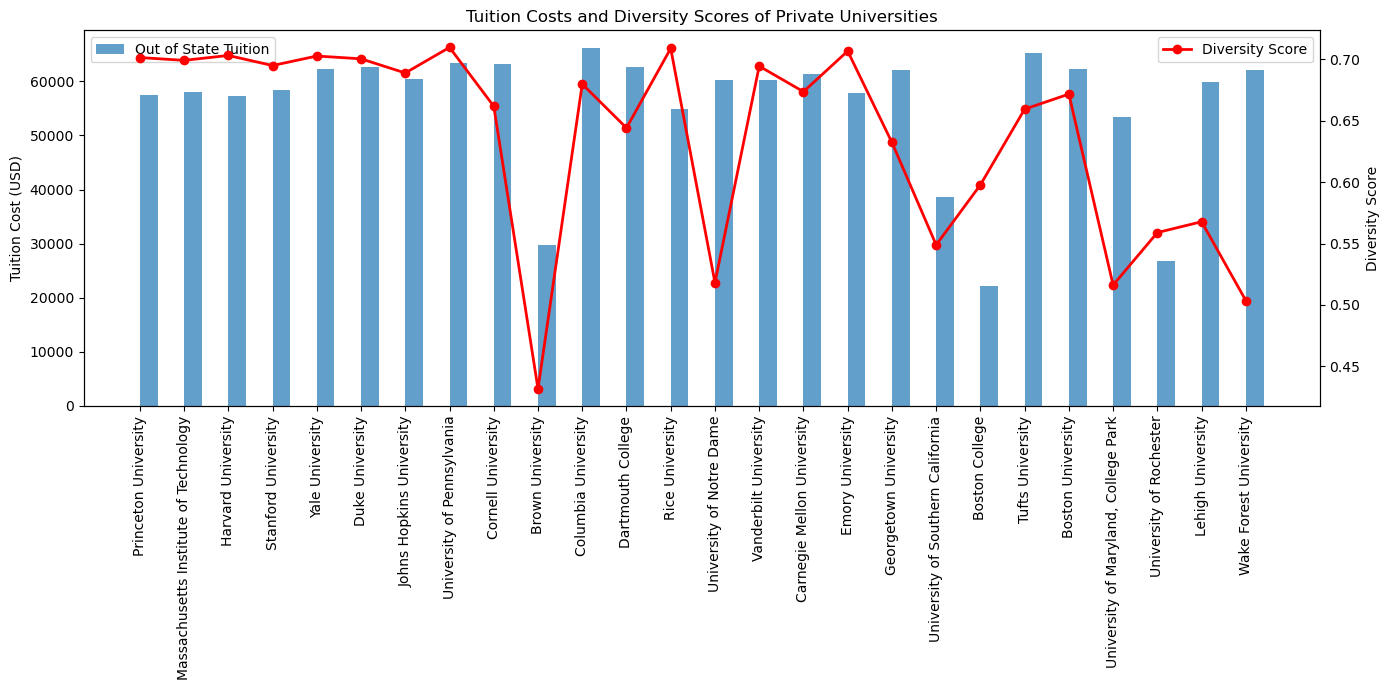

In [31]:
# Create a dual-axis plot for Private universities with Diversity Score & Tuition Cost
fig, ax1 = plt.subplots(figsize=(14, 7))
x = range(len(private_uni_data))
ax1.bar([i + 0.4 for i in x], private_uni_data["Out of State Tuition"], width=0.4, label='Out of State Tuition', align='center', alpha=0.7)
ax1.set_ylabel("Tuition Cost (USD)")
ax1.set_xticks([i + 0.2 for i in x])
ax1.set_xticklabels(private_uni_data["University Name"], rotation=90)
ax1.set_title("Tuition Costs and Diversity Scores of Private Universities")
ax1.legend(loc="upper left")
ax2 = ax1.twinx()
ax2.plot([i + 0.2 for i in x], private_uni_data["Diversity Score"], color='red', marker='o', label='Diversity Score', linewidth=2)
ax2.set_ylabel("Diversity Score")
ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()

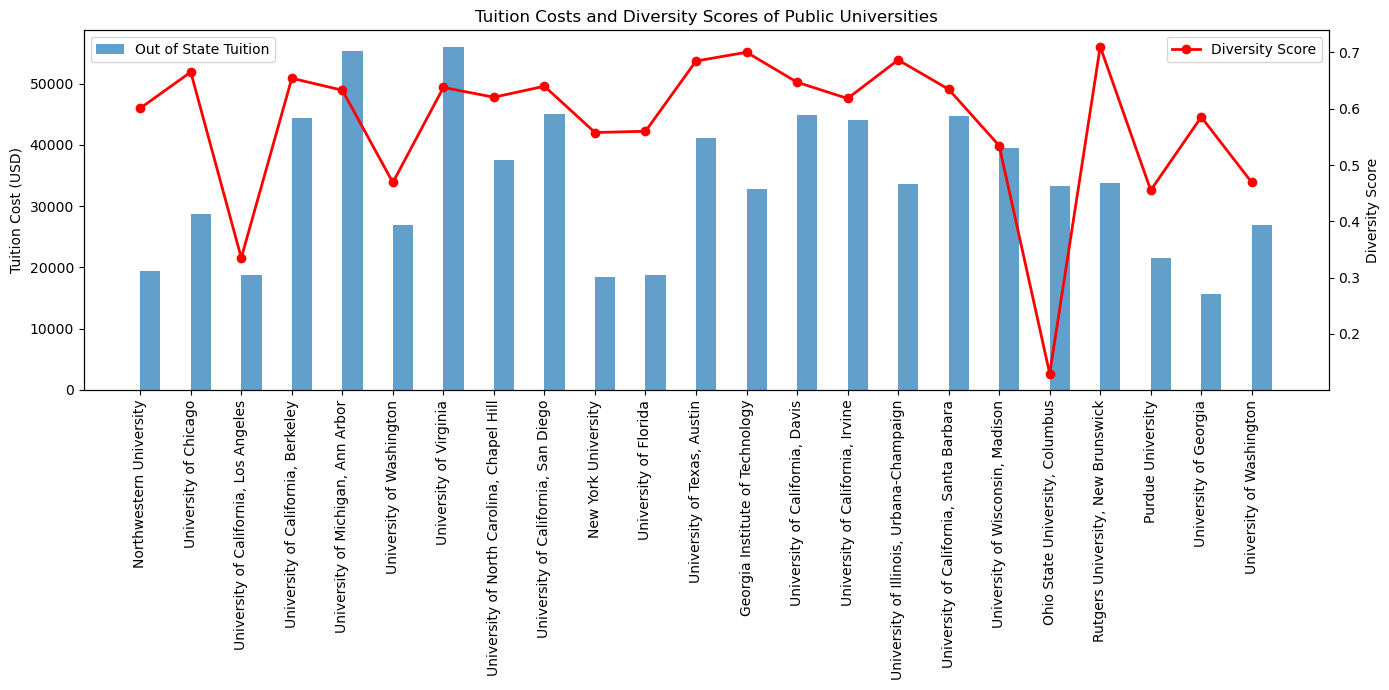

In [32]:
# Create a dual-axis plot for Public universities with Diversity Score & Tuition Cost
fig, ax1 = plt.subplots(figsize=(14, 7))
x = range(len(public_uni_data))
ax1.bar([i + 0.4 for i in x], public_uni_data["Out of State Tuition"], width=0.4, label='Out of State Tuition', align='center', alpha=0.7)
ax1.set_ylabel("Tuition Cost (USD)")
ax1.set_xticks([i + 0.2 for i in x])
ax1.set_xticklabels(public_uni_data["University Name"], rotation=90)
ax1.set_title("Tuition Costs and Diversity Scores of Public Universities")
ax1.legend(loc="upper left")
ax2 = ax1.twinx()
ax2.plot([i + 0.2 for i in x], public_uni_data["Diversity Score"], color='red', marker='o', label='Diversity Score', linewidth=2)
ax2.set_ylabel("Diversity Score")
ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()

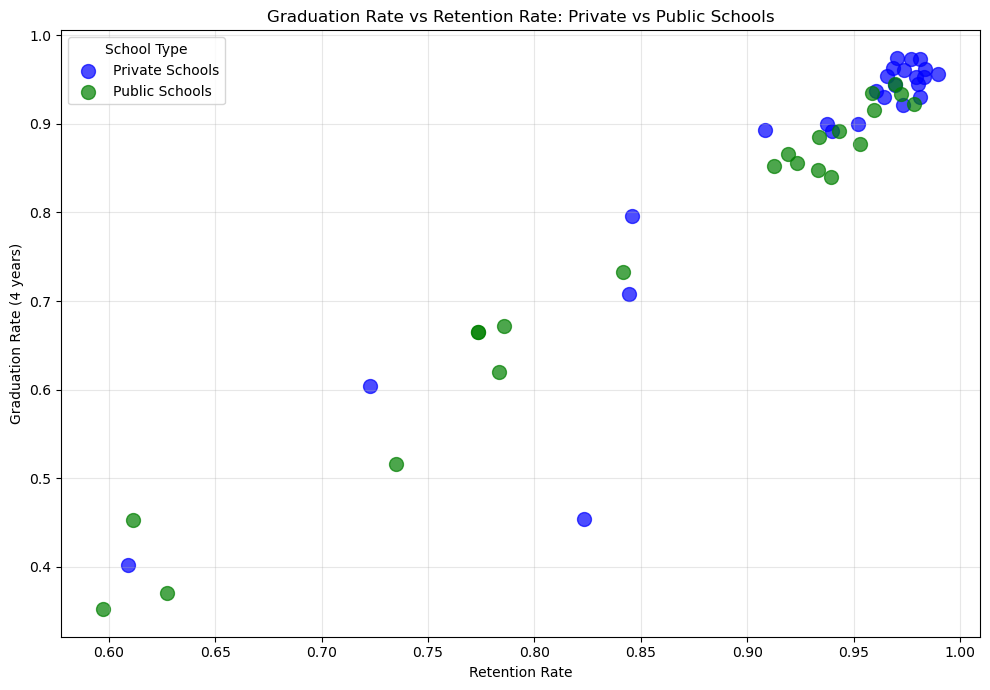

In [33]:
# Create a scatter plot for Graduation Rate vs Retention Rate
plt.figure(figsize=(10, 7))
plt.scatter(private_uni_data["Retention Rate"], private_uni_data["Graduation Rate 4-years"],color='blue', label='Private Schools', alpha=0.7, s=100)
plt.scatter(public_uni_data["Retention Rate"], public_uni_data["Graduation Rate 4-years"],color='green', label='Public Schools', alpha=0.7, s=100)
z_private = np.polyfit(private_uni_data["Retention Rate"], private_uni_data["Graduation Rate 4-years"], 1)
p_private = np.poly1d(z_private)
plt.plot(private_uni_data["Retention Rate"], p_private(private_uni_data["Retention Rate"]), color='blue', linestyle='--')
z_public = np.polyfit(public_uni_data["Retention Rate"], public_uni_data["Graduation Rate 4-years"], 1)
p_public = np.poly1d(z_public)
plt.plot(public_uni_data["Retention Rate"], p_public(public_uni_data["Retention Rate"]), color='green', linestyle='--')
plt.xlabel("Retention Rate")
plt.ylabel("Graduation Rate (4 years)")
plt.title("Graduation Rate vs Retention Rate: Private vs Public Schools")
plt.legend(title="School Type")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

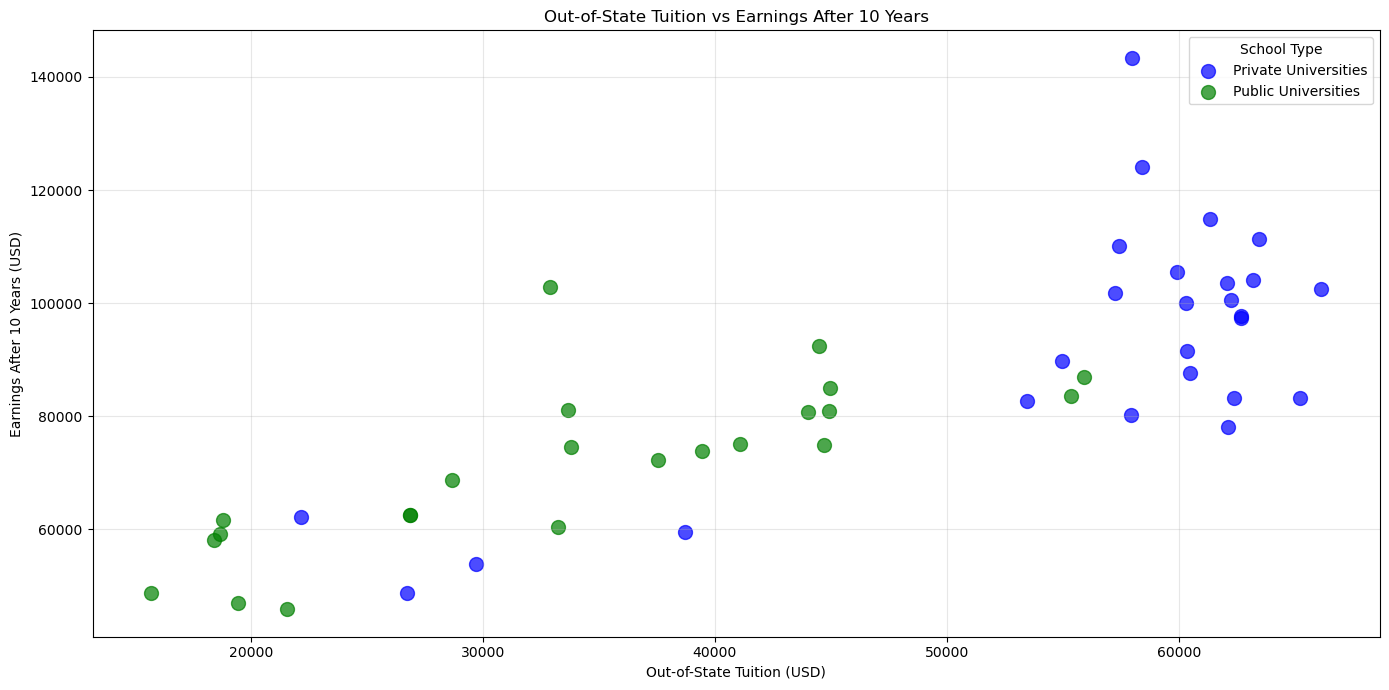

In [34]:
# Create a scatter plot for Out-of-State Tuition vs Earnings After 10 Years
plt.figure(figsize=(14, 7))
plt.scatter(private_uni_data["Out of State Tuition"], private_uni_data["Earnings After 10 Years"],color='blue', alpha=0.7, s=100, label="Private Universities")
plt.scatter(public_uni_data["Out of State Tuition"], public_uni_data["Earnings After 10 Years"],color='green', alpha=0.7, s=100, label="Public Universities")
plt.xlabel("Out-of-State Tuition (USD)")
plt.ylabel("Earnings After 10 Years (USD)")
plt.title("Out-of-State Tuition vs Earnings After 10 Years")
plt.legend(title="School Type")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()